In [1]:
import matplotlib.pyplot as plt
import nest
import sys
import numpy as np

from bmtk.builder.networks import NetworkBuilder
from bmtk.simulator import pointnet
from bmtk.analyzer.compartment import plot_traces
from bmtk.analyzer.spike_trains import plot_raster

# nest.ResetKernel()
nest.Models(mtype="all")     # Capital "M" for consistency with NEST's language SLI


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: nest-3.0
 Built: Sep 14 2022 22:43:51

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



('ac_generator',
 'aeif_cond_alpha',
 'aeif_cond_alpha_multisynapse',
 'aeif_cond_beta_multisynapse',
 'aeif_cond_exp',
 'aeif_psc_alpha',
 'aeif_psc_delta',
 'aeif_psc_delta_clopath',
 'aeif_psc_exp',
 'amat2_psc_exp',
 'bernoulli_synapse',
 'bernoulli_synapse_hpc',
 'bernoulli_synapse_lbl',
 'clopath_synapse',
 'clopath_synapse_hpc',
 'clopath_synapse_lbl',
 'cont_delay_synapse',
 'cont_delay_synapse_hpc',
 'cont_delay_synapse_lbl',
 'correlation_detector',
 'correlomatrix_detector',
 'correlospinmatrix_detector',
 'dc_generator',
 'diffusion_connection',
 'diffusion_connection_lbl',
 'erfc_neuron',
 'gamma_sup_generator',
 'gap_junction',
 'gap_junction_lbl',
 'gauss_rate_ipn',
 'gif_cond_exp',
 'gif_cond_exp_multisynapse',
 'gif_pop_psc_exp',
 'gif_psc_exp',
 'gif_psc_exp_multisynapse',
 'ginzburg_neuron',
 'glif_cond',
 'glif_psc',
 'glif_psc_bix',
 'hh_cond_beta_gap_traub',
 'hh_cond_exp_traub',
 'hh_psc_alpha',
 'hh_psc_alpha_clopath',
 'hh_psc_alpha_gap',
 'ht_neuron',
 'ht_syn

In [2]:
# baseline iaf with alpha synapse
neuron=nest.Create("iaf_psc_alpha")
nest.SetStatus(neuron, {'I_e': 380.0})  # constant current to drive periodic spiking
multimeter = nest.Create('multimeter', params={'record_from': ['V_m']})
nest.Connect(multimeter,neuron)

In [3]:
nest.Simulate(1000.0)


Aug 24 15:02:08 NodeManager::prepare_nodes [Info]: 
    Preparing 2 nodes for simulation.

Aug 24 15:02:08 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 2
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Aug 24 15:02:08 SimulationManager::run [Info]: 
    Simulation finished.


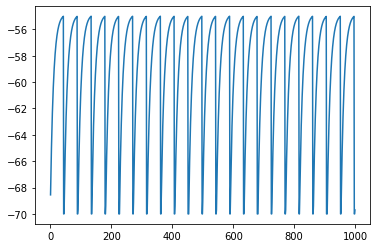

In [4]:
events = nest.GetStatus(multimeter)[0]['events']    # Nest 3 returns objects and uses set() and get()
t = events['times'];

plt.plot(t, events['V_m'])

In [5]:
neuron_post=nest.Create("iaf_psc_alpha")

In [6]:
# Static synapse - Must run each synapse version from scratch or it seems to alter behavior by repeated Connect
syn_dict_in = {"weight": -2.0}
nest.Connect(neuron, neuron_post, syn_spec=syn_dict_in)


Aug 24 15:02:08 ConnectionManager [Warning]: 
    New connections created, connection descriptors previously obtained using 
    'GetConnections' are now invalid.



Aug 24 15:02:08 NodeManager::prepare_nodes [Info]: 
    Preparing 4 nodes for simulation.

Aug 24 15:02:08 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 4
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Aug 24 15:02:08 SimulationManager::run [Info]: 
    Simulation finished.


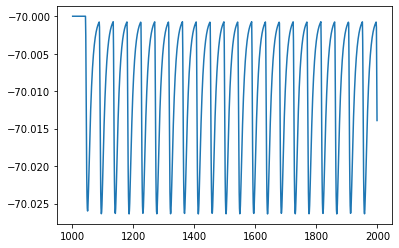

In [7]:
multimeter_post = nest.Create('multimeter', params={'record_from': ['V_m']})
nest.Connect(multimeter_post,neuron_post)

nest.Simulate(1000.0)

events = nest.GetStatus(multimeter_post)[0]['events']    # Nest 3 returns objects and uses set() and get()
t = events['times'];

plt.plot(t, events['V_m'])

In [8]:
# Alternative STDP synapse with distributed values
alpha_min = 0.1
alpha_max = 2.
w_min = 0.5
w_max = 5.

# In Nest 3, this is synapse_model rather than model
syn_dict = {"model": "stdp_synapse",
            "alpha": np.random.uniform(low=alpha_min, high=alpha_max),
            "weight": np.random.uniform(low=w_min, high=w_max),
            "delay": 1.0}

nest.Connect(neuron, neuron_post, syn_spec=syn_dict)
        


Aug 24 15:02:09 ConnectionManager [Warning]: 
    New connections created, connection descriptors previously obtained using 
    'GetConnections' are now invalid.



Aug 24 15:02:09 NodeManager::prepare_nodes [Info]: 
    Preparing 5 nodes for simulation.

Aug 24 15:02:09 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 5
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Aug 24 15:02:09 SimulationManager::run [Info]: 
    Simulation finished.


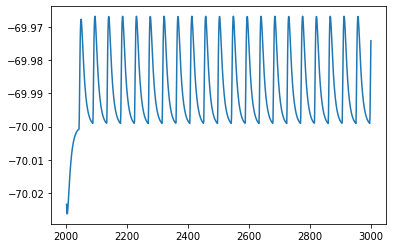

In [9]:
multimeter_post = nest.Create('multimeter', params={'record_from': ['V_m']})
nest.Connect(multimeter_post,neuron_post)

nest.Simulate(1000.0)

events = nest.GetStatus(multimeter_post)[0]['events']    # Nest 3 returns objects and uses set() and get()
t = events['times'];

plt.plot(t, events['V_m'])

In [10]:
# Alternative Tsodyks STP synapse - see caveat about needing PSC to be certain forms for interpretation
dep_params = {"U": 0.67, "u": 0.67, 'x': 1.0, "tau_rec": 450.0,
              "tau_fac": 0.0, "weight": 250.}

nest.CopyModel("tsodyks_synapse", "dep_syn", dep_params)

nest.Connect(neuron, neuron_post, syn_spec="dep_syn")


Aug 24 15:02:09 ConnectionManager [Warning]: 
    New connections created, connection descriptors previously obtained using 
    'GetConnections' are now invalid.



Aug 24 15:02:09 NodeManager::prepare_nodes [Info]: 
    Preparing 6 nodes for simulation.

Aug 24 15:02:09 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 6
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Aug 24 15:02:09 SimulationManager::run [Info]: 
    Simulation finished.


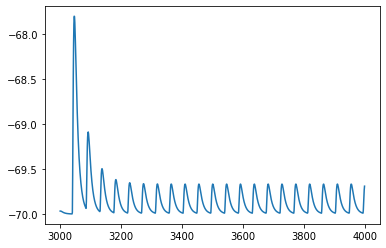

In [11]:
multimeter_post = nest.Create('multimeter', params={'record_from': ['V_m']})
nest.Connect(multimeter_post,neuron_post)

nest.Simulate(1000.0)

events = nest.GetStatus(multimeter_post)[0]['events']    # Nest 3 returns objects and uses set() and get()
t = events['times'];

plt.plot(t, events['V_m'])

In [12]:
# Alternative Tsodyks2 depressing - x has different meaning here
dep_params = {"U": 0.67, "u": 0.67, "tau_rec": 450.0,
              "tau_fac": 0.0, "weight": 250.}

nest.CopyModel("tsodyks2_synapse", "dep_syn2", dep_params)

nest.Connect(neuron, neuron_post, syn_spec="dep_syn2")


Aug 24 15:02:09 ConnectionManager [Warning]: 
    New connections created, connection descriptors previously obtained using 
    'GetConnections' are now invalid.



Aug 24 15:02:09 NodeManager::prepare_nodes [Info]: 
    Preparing 7 nodes for simulation.

Aug 24 15:02:09 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 7
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Aug 24 15:02:09 SimulationManager::run [Info]: 
    Simulation finished.


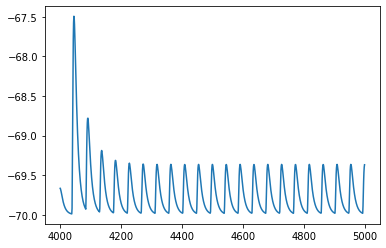

In [13]:
multimeter_post = nest.Create('multimeter', params={'record_from': ['V_m']})
nest.Connect(multimeter_post,neuron_post)

nest.Simulate(1000.0)

events = nest.GetStatus(multimeter_post)[0]['events']    # Nest 3 returns objects and uses set() and get()
t = events['times'];

plt.plot(t, events['V_m'])

In [14]:
# Alternative Tsodyks2 facilitating - x has different meaning here
# Doesn't allow depression of 0.0
fac_params = {"U": 0.3, "u": 0.3, "tau_rec": 1.0,
              "tau_fac": 200.0, "weight": 250.}

nest.CopyModel("tsodyks2_synapse", "fac_syn", fac_params)

nest.Connect(neuron, neuron_post, syn_spec="fac_syn")


Aug 24 15:02:09 ConnectionManager [Warning]: 
    New connections created, connection descriptors previously obtained using 
    'GetConnections' are now invalid.



Aug 24 15:02:09 NodeManager::prepare_nodes [Info]: 
    Preparing 8 nodes for simulation.

Aug 24 15:02:09 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 8
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Aug 24 15:02:09 SimulationManager::run [Info]: 
    Simulation finished.


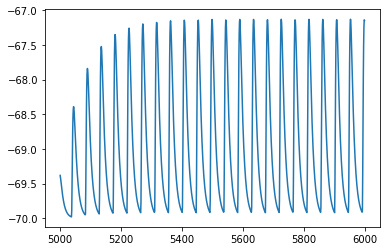

In [15]:
multimeter_post = nest.Create('multimeter', params={'record_from': ['V_m']})
nest.Connect(multimeter_post,neuron_post)

nest.Simulate(1000.0)

events = nest.GetStatus(multimeter_post)[0]['events']    # Nest 3 returns objects and uses set() and get()
t = events['times'];

plt.plot(t, events['V_m'])

In [16]:
# Tsodyks2 without copying model 

fac_params2 = {"model": "tsodyks2_synapse", 
              "U": 0.3, 
              "u": 0.3, 
              "tau_rec": 1.0,
              "tau_fac": 200.0, 
              "weight": 250.}

nest.Connect(neuron, neuron_post, syn_spec=fac_params2)


Aug 24 15:02:09 ConnectionManager [Warning]: 
    New connections created, connection descriptors previously obtained using 
    'GetConnections' are now invalid.



Aug 24 15:02:09 NodeManager::prepare_nodes [Info]: 
    Preparing 9 nodes for simulation.

Aug 24 15:02:09 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Aug 24 15:02:09 SimulationManager::run [Info]: 
    Simulation finished.


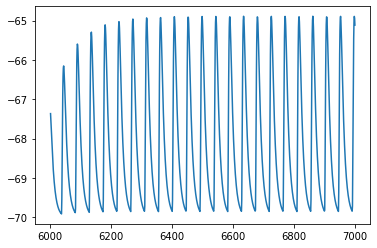

In [17]:
multimeter_post = nest.Create('multimeter', params={'record_from': ['V_m']})
nest.Connect(multimeter_post,neuron_post)

nest.Simulate(1000.0)

events = nest.GetStatus(multimeter_post)[0]['events']    # Nest 3 returns objects and uses set() and get()
t = events['times'];

plt.plot(t, events['V_m'])

In [3]:
# Does this work in BMTK?
# Basic network

net = NetworkBuilder('two_cell')

# Build Nodes

net.add_nodes(
    N=1,
    model_type='point_neuron',
    model_template= 'nest:iaf_psc_alpha',
    dynamics_params='472363762_point_with_cc.json',
    ei_type='e',
    pop_name='presyn'
)

net.add_nodes(
    N=1,
    model_type='point_neuron',
    model_template= 'nest:iaf_psc_alpha',
    dynamics_params='472363762_point.json',
    ei_type='e',
    pop_name='postsyn'
)

net.add_edges(
    source=net.nodes(pop_name='presyn'),
    target=net.nodes(pop_name='postsyn'),
    connection_rule = 5,
    model_template='static_synapse',
    dynamics_params='ExcToExc.json',   #'static_ExcToExc.json' for glif
    delay=2.0,
    syn_weight=100
)

net.build()
net.save(output_dir='network')

In [19]:
from bmtk.utils.create_environment import create_environment

create_environment(
    'pointnet',
    base_dir='.',
    config_file='config.pointnet.json',
    network_dir='network',
    output_dir='output_pointnet',
    tstop=3000.0, dt=0.1,
#    current_clamp= {
#        'amp': 0.150,                  # Current size (pA)
#        'delay': 500,                  # Time from start of simulation to onset of step (ms)
#        'duration': 2000               # Duration of current step (ms)
#    },
    report_vars=['V_m'],                 # Record membrane potential
#    report_vars=[('l4', 'V_m')],
    run_script='run_pointnet.py',
    # overwrite=True,
)


ERROR:root:Configuration file /home/ping/bmtk_change/bmtk/XPL_dyn_syn_test/config.pointnet.json already exists, skipping. Please delete existing file, use a different name, or use overwrite=True.


In [20]:
from bmtk.simulator import pointnet

configure = pointnet.Config.from_json('config.pointnet.json')
configure.build_env()

network = pointnet.PointNetwork.from_config(configure)
sim = pointnet.PointSimulator.from_config(configure, network)
sim.run()

2022-08-24 15:02:10,103 [INFO] Created log file


INFO:NestIOUtils:Created log file


2022-08-24 15:02:10,116 [INFO] Batch processing nodes for two_cell/0.


INFO:NestIOUtils:Batch processing nodes for two_cell/0.


2022-08-24 15:02:10,134 [INFO] Setting up output directory


INFO:NestIOUtils:Setting up output directory


2022-08-24 15:02:10,136 [INFO] Building cells.


INFO:NestIOUtils:Building cells.


2022-08-24 15:02:10,140 [INFO] Building recurrent connections


INFO:NestIOUtils:Building recurrent connections


2022-08-24 15:02:10,146 [INFO] Network created.


INFO:NestIOUtils:Network created.


2022-08-24 15:02:10,151 [INFO] Starting Simulation


INFO:NestIOUtils:Starting Simulation


2022-08-24 15:02:10,289 [INFO] Simulation finished, finalizing results.


INFO:NestIOUtils:Simulation finished, finalizing results.


2022-08-24 15:02:10,343 [INFO] Done.


INFO:NestIOUtils:Done.


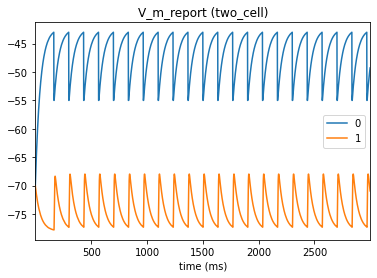

In [21]:
_ = plot_traces(config_file='config.pointnet.json', report_name='V_m_report', node_ids = [0, 1])

In [2]:
# With facilitation

net = NetworkBuilder('two_cell')

# Build Nodes

net.add_nodes(
    N=1,
    model_type='point_neuron',
    model_template= 'nest:iaf_psc_alpha',
    dynamics_params='472363762_point_with_cc.json',
    ei_type='e',
    pop_name='presyn'
)

net.add_nodes(
    N=1,
    model_type='point_neuron',
    model_template= 'nest:iaf_psc_alpha',
    dynamics_params='472363762_point.json',
    ei_type='e',
    pop_name='postsyn'
)

net.add_edges(
    source=net.nodes(pop_name='presyn'),
    target=net.nodes(pop_name='postsyn'),
    connection_rule = 5,
    model_template='tsodyks2_synapse',
    dynamics_params='TsodyksFac.json',   #'static_ExcToExc.json' for glif
    delay=2.0,
    syn_weight=100
)

net.build()
net.save(output_dir='network')

In [3]:
from bmtk.utils.create_environment import create_environment

create_environment(
    'pointnet',
    base_dir='.',
    config_file='config.pointnet2.json',
    network_dir='network',
    output_dir='output_pointnet',
    tstop=3000.0, dt=0.1,
    report_vars=['V_m'],                 # Record membrane potential
    run_script='run_pointnet.py',
    # overwrite=True,
)

configure = pointnet.Config.from_json('config.pointnet.json')
configure.build_env()

network = pointnet.PointNetwork.from_config(configure)
sim = pointnet.PointSimulator.from_config(configure, network)
sim.run()


2022-09-22 15:50:23,830 [INFO] Created log file


INFO:NestIOUtils:Created log file


2022-09-22 15:50:23,845 [INFO] Batch processing nodes for two_cell/0.


INFO:NestIOUtils:Batch processing nodes for two_cell/0.


2022-09-22 15:50:23,856 [INFO] Setting up output directory


INFO:NestIOUtils:Setting up output directory


2022-09-22 15:50:23,858 [INFO] Building cells.


INFO:NestIOUtils:Building cells.


2022-09-22 15:50:23,863 [INFO] Building recurrent connections


INFO:NestIOUtils:Building recurrent connections


2022-09-22 15:50:23,872 [INFO] Network created.


INFO:NestIOUtils:Network created.


2022-09-22 15:50:23,878 [INFO] Starting Simulation


INFO:NestIOUtils:Starting Simulation


2022-09-22 15:50:23,994 [INFO] Simulation finished, finalizing results.


INFO:NestIOUtils:Simulation finished, finalizing results.


2022-09-22 15:50:24,034 [INFO] Done.


INFO:NestIOUtils:Done.


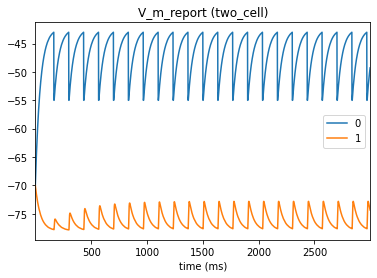

In [4]:
_ = plot_traces(config_file='config.pointnet2.json', report_name='V_m_report', node_ids = [0, 1])
# Makes effective synaptic weight lower? and firing-rate-dependent?

In [2]:
# With GLIF

net = NetworkBuilder('two_cell')

# Build Nodes

net.add_nodes(
    N=1,
    model_type='point_neuron',
    model_template= 'nest:iaf_psc_alpha',
    dynamics_params='472363762_point_with_cc.json',
    ei_type='e',
    pop_name='presyn'
)

net.add_nodes(
    N=1,
    model_type='point_neuron',
    model_template= 'nest:glif_lif_asc_psc',
    dynamics_params='Scnn1a_515806250_glif_lif_asc.json',
    ei_type='e',
    pop_name='postsyn'
)

# Had to scale down synweight for glif
net.add_edges(
    source=net.nodes(pop_name='presyn'),
    target=net.nodes(pop_name='postsyn'),
    connection_rule = 1,
    #model_template='static_synapse',
    #dynamics_params='static_ExcToExc.json',     
    model_template='tsodyks2_synapse',
    dynamics_params='TsodyksFac_glif.json',   #'static_ExcToExc.json' for glif
    delay=2.0,
    syn_weight=-100
)

net.build()
net.save(output_dir='network')

In [ ]:
from bmtk.utils.create_environment import create_environment

create_environment(
    'pointnet',
    base_dir='.',
    config_file='config.pointnet2.json',
    network_dir='network',
    output_dir='output_pointnet',
    tstop=3000.0, dt=0.1,
    report_vars=['V_m'],
    run_script='run_pointnet.py',
    overwrite=True,
)

configure = pointnet.Config.from_json('config.pointnet2.json')
configure.build_env()

network = pointnet.PointNetwork.from_config(configure)
sim = pointnet.PointSimulator.from_config(configure, network)
sim.run()


In [ ]:
_ = plot_traces(config_file='config.pointnet2.json', report_name='V_m_report', node_ids = [0])

In [ ]:
_ = plot_traces(config_file='config.pointnet2.json', report_name='V_m_report', node_ids = [1])

In [7]:
from bmtk.utils.create_environment import create_environment

create_environment(
    'pointnet',
    base_dir='.',
    config_file='config.pointnet2.json',
    network_dir='network',
    output_dir='output_pointnet',
    tstop=3000.0, dt=0.1,
    report_vars=['V_m'],
    run_script='run_pointnet.py',
    current_clamp= {
        "input_type": "current_clamp",
        "module": "IClamp",
        'amp': 200.000,                  # Current size (pA)
        'delay': 500.0,                  # Time from start of simulation to onset of step (ms)
        'duration': 2000.0,               # Duration of current step (ms)
        'node_set': {
            "population": "two_cell",
            "node_id": [0]
         }
    },
    overwrite=True,
)

In [8]:
configure = pointnet.Config.from_json('config.pointnet2.json')
configure.build_env()

network = pointnet.PointNetwork.from_config(configure)
sim = pointnet.PointSimulator.from_config(configure, network)
sim.run()


2022-08-25 15:37:52,178 [INFO] Created log file


INFO:NestIOUtils:Created log file


2022-08-25 15:37:52,203 [INFO] Batch processing nodes for two_cell/0.


INFO:NestIOUtils:Batch processing nodes for two_cell/0.


2022-08-25 15:37:52,219 [INFO] Setting up output directory


INFO:NestIOUtils:Setting up output directory


2022-08-25 15:37:52,221 [INFO] Building cells.


INFO:NestIOUtils:Building cells.


2022-08-25 15:37:52,226 [INFO] Building recurrent connections


INFO:NestIOUtils:Building recurrent connections


2022-08-25 15:37:52,233 [INFO] Network created.


INFO:NestIOUtils:Network created.


2022-08-25 15:37:52,238 [INFO] Starting Simulation


INFO:NestIOUtils:Starting Simulation


2022-08-25 15:37:52,609 [INFO] Simulation finished, finalizing results.


INFO:NestIOUtils:Simulation finished, finalizing results.


2022-08-25 15:37:52,655 [INFO] Done.


INFO:NestIOUtils:Done.


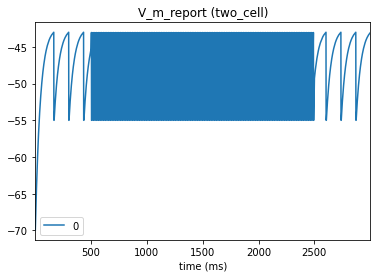

In [9]:
_ = plot_traces(config_file='config.pointnet2.json', report_name='V_m_report', node_ids = [0])

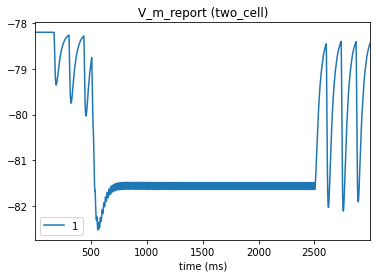

In [10]:
_ = plot_traces(config_file='config.pointnet2.json', report_name='V_m_report', node_ids = [1])